In [1]:
# coding: utf-8

from __future__ import division
from __future__ import print_function

import numpy as np
import emcee
import pyspike as spk
import neurofit as nf
import neurofit.cneurons as cn

from scipy.signal import decimate, resample

import utils
import os
import shutil
import time
from os import walk
import sys

#plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
import pandas as pd             # data analysis and manipulation package
from corner import corner 

sns.set_style('white')
clr = sns.color_palette('cubehelix',4)
sns.set_palette(sns.color_palette(clr))
rcParams['figure.figsize'] = (16,10) 

In [2]:
# define dstrf class
class dstrf():
    def __init__(self,channels=1,nspec=15,upsample=1,scale=1):
        self.mat = nf.models.mat()
        self.pstrf = nf.models.parameterized_strf(channels,nspec)
        self.upsample = upsample
        self.scale = scale
    
    def set(self, theta):
        self.mat.set(theta[:4])
        self.pstrf.set(theta[4:])
        
    def run(self, stim):
        r = self.pstrf.run(stim)
        r = resample(nf.utils.normalize(r),len(r)*self.upsample)*self.scale
        return self.mat.run(r)

In [5]:
# load mcmc results
region = "cm"
cell = "oo1220_1_A"
stim_type = "conspecific"
root = "/scratch/tyler/dstrf/results"
path = "/".join([root,region,cell,""])

results = {}
for f in next(walk(path))[2]:
    name, ext = f.split(".")
    if ext == "npz":
        results[name] = np.load(path+f)
#results = [f for f in next(walk(path))[2] if f.split(".")[1] == "npz"]
R = results[results.keys()[0]]
maxlik = R['maxlik']
chain = R['chain']

In [7]:
# load data from crcns
num_assim_stims = 15

t_dsample = 5
psth_smooth = 5/t_dsample
nspec = 30
channels = 4
scale = 1

spikesroot = "/home/data/crcns/all_cells/" + cell + "/" + stim_type +"/"
stimroot = "/home/data/crcns/all_stims/"

spikefiles = [f for f in next(walk(spikesroot))[2] if len(f.split(".")) == 2]
stimfiles = [f.split(".")[0] + ".wav" for f in spikefiles]

stims,durations = utils.load_sound_data(stimfiles, stimroot, dsample=t_dsample,sres=nspec,gammatone=True)
spikes_data, spiky_data = utils.load_spikes_data(spikefiles, spikesroot, durations)
psth_data = [utils.psth_spiky(spiky,binres=1,smooth=psth_smooth,dsample=t_dsample) for spiky in spiky_data]

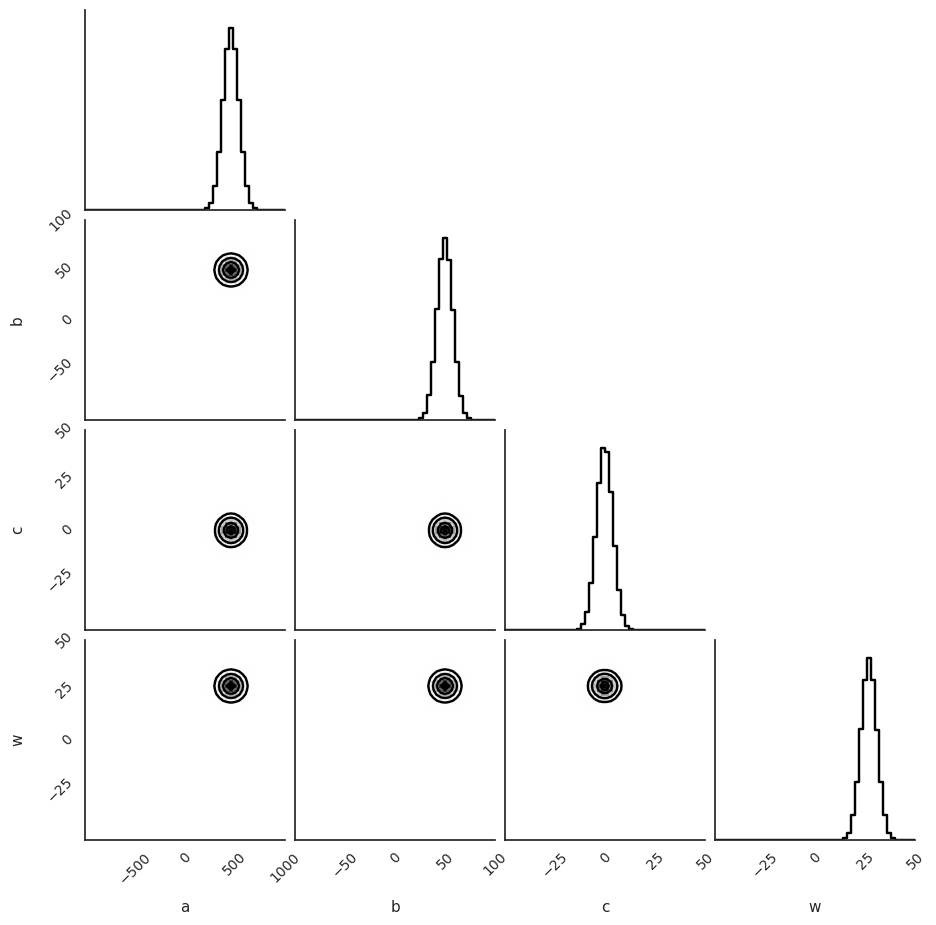

In [33]:
corner(chain[:,:4],bins=50,
       #truths=maxlik[:4],
       smooth=2,smooth1d=2,
      labels=["a","b","c","w"],
      range=[[-1000,1000],
              [-100,100],
            [-50,50],
            [-50,50]]);
sns.despine(right=True)
#savefig("cm_neuron-corner.svg")

In [9]:
maxlik_nrn = dstrf(channels=channels,nspec=nspec,upsample=t_dsample,scale=scale) 
maxlik_nrn.set(maxlik)

dstrf_corr = []
for stim, data in zip(stims,psth_data)[num_assim_stims:]:
    trace,spikes = maxlik_nrn.run(stim)
    dur = len(data)*t_dsample
    mat_psth = utils.psth_spiky(spk.SpikeTrain(spikes,[0,dur]),binres=1,smooth=psth_smooth,dsample=t_dsample)
    corr = np.corrcoef(data+min(data),mat_psth)[0][1]
    dstrf_corr.append(corr)

print("dSTRF R: {:.3f}".format(np.mean(dstrf_corr)))

dSTRF R: 0.580


In [42]:
%%time
for stim in stims:
    maxlik_nrn.run(stim)

CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 23.2 ms


0.566581584652


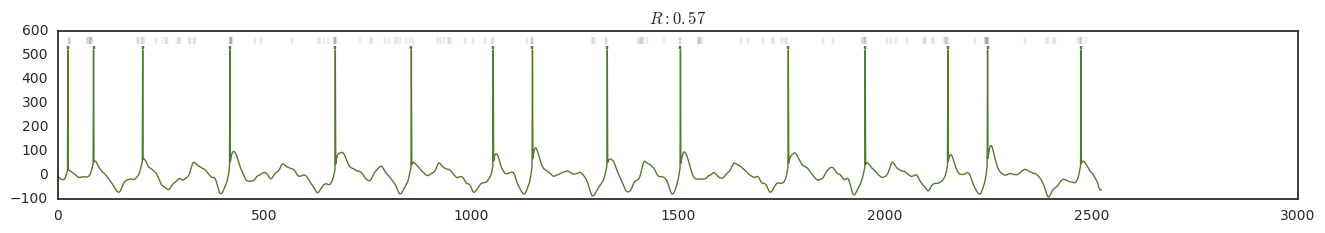

In [11]:
all_corr = []
for j,i in enumerate(stims):
    if j == 17:
        trace, spikes = maxlik_nrn.run(i) 
        V, thresh = trace.T
        height = max(thresh)
        V[spikes] = height
        figure()
        spky = spk.SpikeTrain(spikes,[0,spiky_data[j][0].t_end])
        trialpsth = utils.psth_spiky(spky,binres=1,smooth=psth_smooth,dsample=t_dsample)
        corr = np.corrcoef(trialpsth,psth_data[j])[0][1]
        all_corr.append(corr)
        subplot(411)
        title("$R: {:.2f}$".format(corr))
        plot(V,linewidth=1,color=clr[1])
        vlines(spikes,height+5,height+15,color=clr[1])
        for trial in spiky_data[j]:
            vlines(trial.spikes,height+25,height+55,alpha=0.1,color=clr[0])
print(np.mean(all_corr))

0.429022163904


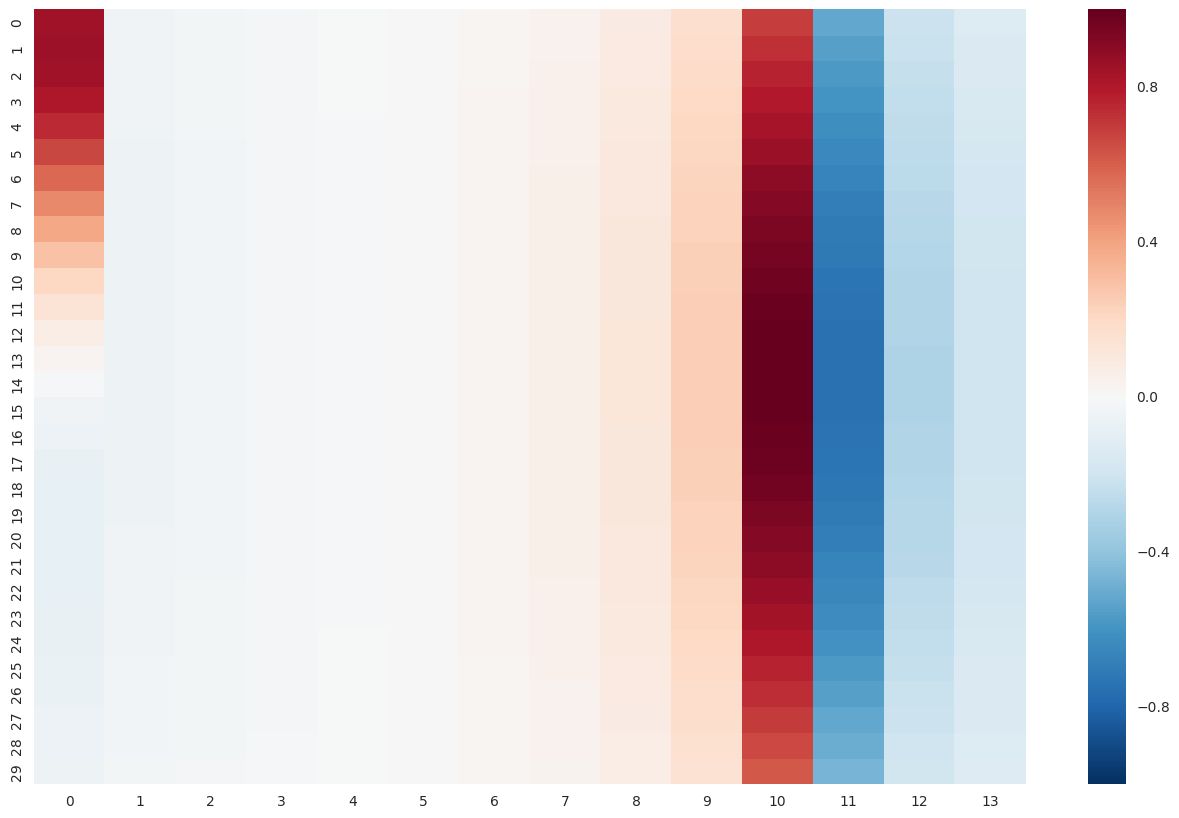

In [12]:
par = nf.models.parameterized_strf(channels=4,nspec=30)
par.set(maxlik[4:])
TEST = par.run(stims[-2])
TEST[TEST<0] = 0
score = np.corrcoef(TEST,psth_data[-2])[0][1]

print(score)

sns.heatmap(par.filt/par.filt.max())

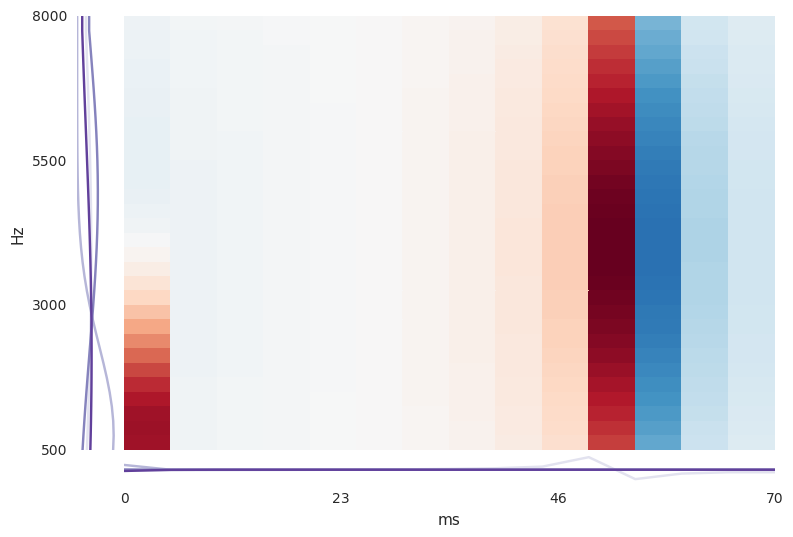

In [13]:
figure(figsize=(9,6))
nf.utils.strf_plot(par.sfilt,par.tfilt,500,8000,5)
#savefig("cm_neuron-strf.svg")

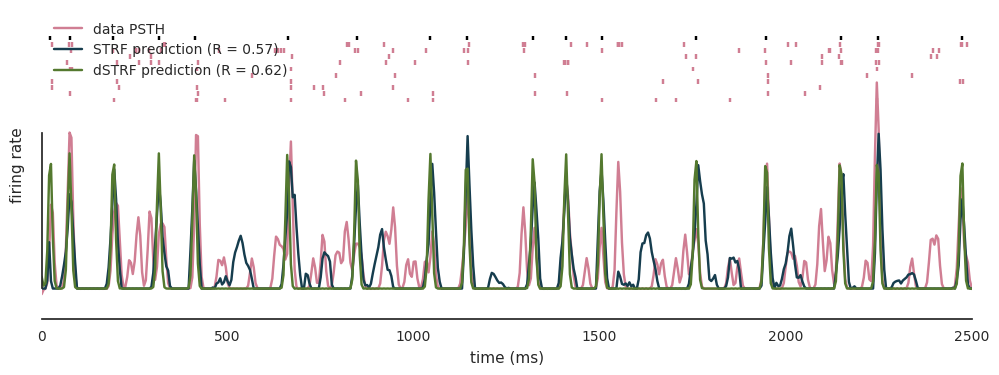

In [42]:
from neurofit.utils import normalize as norm


figure(figsize=(12,4))
plot(norm(psth_data[-2])+0.66,label="data PSTH",color=clr[2])
plot(norm(TEST)+0.6,label="STRF prediction (R = 0.57)")
plot(norm(trialpsth)+0.36,label="dSTRF prediction (R = 0.62)")

vlinesw = 1
vlscale = 5

for i,s in enumerate(spikes_data[-2]):
    vlines(np.asarray(s)/5,6+i/vlscale,6+(i+0.75)/vlscale,color=clr[2])
i+=1
vlines(np.asarray(spikes)/5,6+i/vlscale,6+(i+0.75)/vlscale)

legend(loc=(1,0.5))
    
xlim(0,500)
yticks(np.arange(0,6),[])
xticks(range(0,501,100),range(0,2501,500))
sns.despine(trim=True)

ylabel("firing rate")
xlabel("time (ms)")
savefig("cm_neuron-psth.svg")

In [39]:
figure(figsize=(12,1))
sns.heatmap(hrstims[-2],cbar=False,cmap="gray_r")
sns.despine(left=True,bottom=True)
xticks([]);
yticks([]);
savefig("cm_neuron-stim.svg")

NameError: name 'hrstims' is not defined

In [ ]:
hrstims, __ = utils.load_sound_data(stimfiles, stimroot, dsample=5 , sres=100,gammatone=False,compress=1e5)
